## Collaborative/Personalized Learning

In [12]:
%matplotlib inline
import sys
import os
helpers_path = os.path.abspath('../')
if helpers_path not in sys.path:
    sys.path.append(helpers_path)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import Kernel

from online_kernels.klms import KLMS
from online_kernels.knlms import KNLMS
from online_kernels.krls import KRLS
from online_kernels.klmsRFF import klms_rff
from online_kernels.knlmsRFF import knlms_rff
from online_kernels.krlsRFF import krls_rff

from data.datasets import load_dodd
from sklearn.utils import shuffle
from scipy.optimize import nnls

100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 40.40it/s]


Text(0.5, 0, 'iteration')

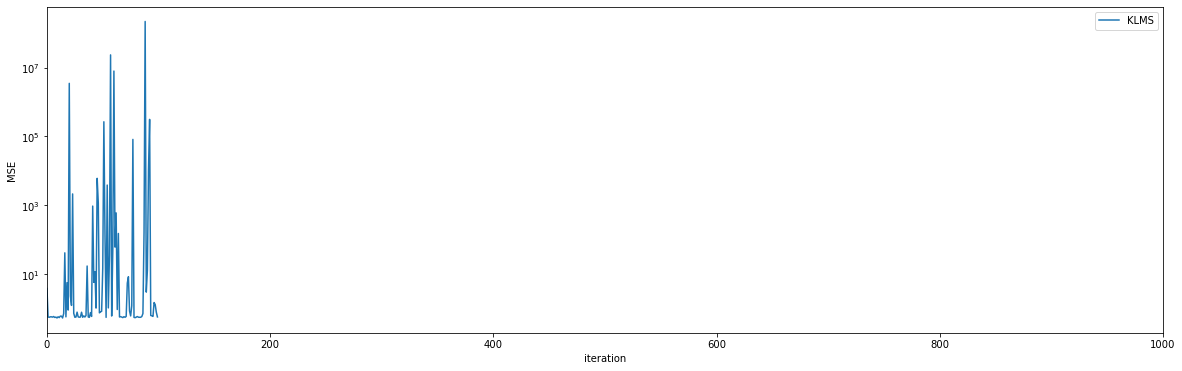

In [269]:
iteration = 100
mse = np.zeros(iteration)
# Kernel Dictionary size

step_size = 0.08
num_data=3000


# N individuals
N = 10 # mFea
# L canonical models
L = 30 # k
D = 100 # p
KLMS_RFF = klms_rff(step_size,D)
num_experiments = 1
C = np.abs(np.random.rand(L,N)) # membership weight matrix W
A = np.random.rand(D,L) # B
u,d,d_true = load_dodd(num_data)
kernel = Kernel(3.73)
sigma = 1/np.sqrt(2*kernel.sigma)
W = (1/sigma) * np.random.normal(size=(2,D))
b = np.random.uniform(0,2*np.pi,(D,1))
h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)
K = []


for n in tqdm(range(iteration)):
    Y_hat = []
    Y = []
    err = 0
    # Learning A gived fixed Cs (Least Squares)
    B = np.zeros((D,N))
    m = 0
    for i in range(N):
#         m_i = np.random.randint(1,10)  # nSmp
        m_i = 100
        m += m_i
        K_i = np.zeros((D,m_i))
        Y_i = np.zeros((m_i,))
        c_i = C.T[i]
        for samples in range(m_i):
            v = np.random.randint(len(d))
            h_n = h[:,v].reshape((D,1))
            d_n = np.array([d[v]])
            K_i.T[samples] = h_n.reshape((D,))
            Y_i[samples] = d_n
            if samples > 0:
                alpha_in = alpha_out
            else:
                alpha_in = (A @ c_i).reshape((D,1))
            _,alpha_out = KLMS_RFF.train(h_n,d_n,alpha_in)
#             print('alpha',alpha_out)
        K.append(K_i)
        Y.append(Y_i)
#         Y_i_hat = K_i.T @ A @ c_i
        
        B.T[i] = alpha_out.reshape((D,))
    A_hat,_,_,_ = np.linalg.lstsq(C.T, B.T,rcond=None)
#     TODO: use non-negative least squares optimization
#     A_hat,_ = nnls(C.T, B.T)     
    A = A_hat.T

    # Learning C given the A are fixed
    for i in range(N):
        y_i = Y[i]
        AK = A.T @ K[i]
        AKy = AK @ y_i
        AKKAc = AK @ AK.T @ C.T[i]
        for k in range(L):
            C[k][i] = np.multiply(C[k][i],np.divide(AKy[k],AKKAc[k]))
            
        Y_hat.append(K[i].T @ A @ C.T[i])  

        err+=np.mean(np.square(Y[i] - Y_hat[i]))/N 

    mse[n] = err
plt.figure(figsize=(2*10, 6))
plt.semilogy(range(len(mse)),mse,label="KLMS")
plt.legend()
# plt.ylim([1e-2,1e0])
plt.xlim([0,1000])
plt.ylabel("MSE")
plt.xlabel("iteration")

In [144]:
iteration = 1
# N individuals
N = 10
# p features
p = 2
# K canonical models (personalized learning systems)
K = 5
# L 
L = 3
# Kernel Dictionary size
D = 50
num_experiments = 1
C = np.ones((K,N))
A = np.zeros((D,K))
# u,d,d_true = load_dodd(num_data)

# W = (1/sigma) * np.random.normal(size=(2,D))
# b = np.random.uniform(0,2*np.pi,(D,1))
# h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)

for i in tqdm(range(iteration)):
#     v = np.random.randint(len(d))
    
    for edge in range(N):
        # Learning A gived fixed Cs (Least Squares)  
            # Convert c to C
        C_i = np.append(C.T[edge],np.zeros((K*(p-1))))
        for k in range(p-1):
            C_i = np.vstack((C_i,np.roll(np.append(C.T[edge],np.zeros((K*(p-1)))),K*(k+1))))

        # Learn C given the A are fixed (Difficult)
        # This is an iteration process (nonconvex)



        # Calculate a

        # Convert a to A

        # Calculate C
        C = 

SyntaxError: invalid syntax (3653499060.py, line 41)